## Break a Captcha

Source: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710

download the code from: https://s3-us-west-2.amazonaws.com/mlif-example-code/solving_captchas_code_examples.zip, and run the `extract_single_letters_from_captcha.py`

In [1]:
import os
import sys

# third parties module
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten, Dense

# local module
from captcha_util import split_captcha, resize_to_fit

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Using TensorFlow backend.
/root/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/envs/de

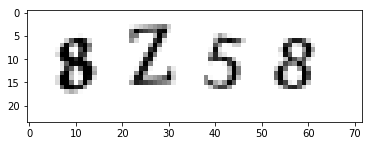

In [2]:
path_data = os.path.abspath (os.path.dirname ('../../data/captcha/generated_captcha_images/'))

# show sample captcha
sample = os.path.join (path_data, '8Z58.png')
img = cv2.imread (sample)
plt.imshow (img)
plt.show ()

In [3]:
# split per letters
letters = split_captcha (img)

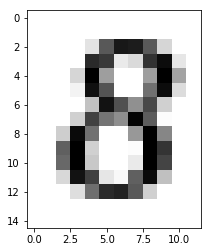

In [4]:
plt.imshow (letters[3], cmap="gray")
plt.show ()

Before transformation : (17, 13)
After transformation : (20, 20)


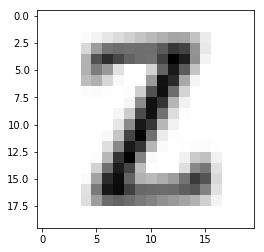

In [5]:
# rescale to the same size
l = letters[1]
print ("Before transformation : {}".format (l.shape))
l = resize_to_fit (l, 20, 20)
print ("After transformation : {}".format (l.shape))
plt.imshow (l, cmap="gray")
plt.show ()

In [6]:
# extract feature from all data
data = []
label = []
for fname in os.listdir (path_data):
    if not fname.endswith ("png"):
        continue
        
    img = cv2.imread (os.path.join (path_data, fname))
    letters = split_captcha (img)
    
    if letters is not None:
        letters = [resize_to_fit (l,20,20) for l in letters]
        data.extend (letters)
        label.extend (list (fname[:-4]))

print ("Total data {}, total label {}".format (len (data), len (label)))

Total data 38744, total label 38744


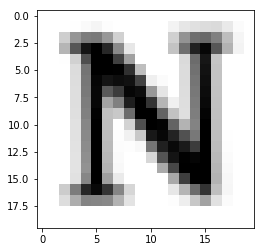

Label N


In [7]:
rid = 214
plt.imshow (data[rid], cmap="gray")
plt.show ()
print ("Label {}".format (label[rid]))

In [8]:
for d in range (len (data)):
    data[d] = np.expand_dims (data[d], axis=2)
data = np.array (data) / 255.0
labels = np.array (label)

In [9]:
# split data train and test
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.25, random_state=0)

In [10]:
# one-hot encoding target, based on training label only
LB = LabelBinarizer().fit(Y_train)
Y_train = LB.transform (Y_train)
Y_test = LB.transform (Y_test)

In [11]:
# the model
model = Sequential()

# First convolutional layer with max pooling
model.add(Conv2D(20, (5, 5), padding="same", input_shape=(20, 20, 1), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Second convolutional layer with max pooling
model.add(Conv2D(50, (5, 5), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Hidden layer with 500 nodes
model.add(Flatten())
model.add(Dense(500, activation="relu"))

# Output layer with 32 nodes (one for each possible letter/number we predict)
model.add(Dense(32, activation="softmax"))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_VISIBLE_DEVICES=""


In [13]:
# Ask Keras to build the TensorFlow model behind the scenes
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# actual train
model.fit(X_train, Y_train, batch_size=32, epochs=10, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
29058/29058 [==============================] - 28s 952us/step - loss: 0.2004 - acc: 0.9537
Epoch 2/10
29058/29058 [==============================] - 26s 900us/step - loss: 0.0119 - acc: 0.9969
Epoch 3/10
29058/29058 [==============================] - 26s 896us/step - loss: 0.0053 - acc: 0.9987
Epoch 4/10
29058/29058 [==============================] - 26s 903us/step - loss: 0.0059 - acc: 0.9987
Epoch 5/10
29058/29058 [==============================] - 26s 897us/step - loss: 0.0035 - acc: 0.9988
Epoch 6/10
29058/29058 [==============================] - 25s 875us/step - loss: 0.0031 - acc: 0.9990
Epoch 7/10
29058/29058 [==============================] - 25s 857us/step - loss: 0.0044 - acc: 0.9986
Epoch 8/10
29058/29058 [==============================] - 25s 854us/step - loss: 0.0019 - acc: 0.9995
Epoch 9/10
29058/29058 [==============================] - 25s 852us/step - loss: 0.0024 - acc: 0.9995
Epoch 10/10
29058/29058 [=========

In [39]:
predict = model.predict (np.array ([X_test[0]]))
idx = np.argmax (predict)
print ("Predicted : {}".format (LB.classes_[idx]))
real_idx = np.argmax (Y_test[0])
print ("Label : {}".format (LB.classes_[real_idx]))

Predicted : J
Label : J
